In [1]:
# Geothermal Energy Forecasting - Complete Implementation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

print("Starting Geothermal Energy Forecasting - Optimized Implementation...")


Starting Geothermal Energy Forecasting - Optimized Implementation...


In [2]:
# 1. Data Loading - Special Handling for Geothermal Energy
print("1. Data Loading - Geothermal Energy Focus")
print("=" * 50)

# Load data
DATA_PATH = "../../training_data.csv"
df = pd.read_csv(DATA_PATH)

# KEY DIFFERENCE: Geothermal energy started later, so treat 0 as missing
# Commercial geothermal development began in late 1980s
df["Geothermal Energy"].replace(0, np.nan, inplace=True)
df.dropna(subset=["Geothermal Energy"], inplace=True)

print(f"After removing zeros/NaN: {len(df)} records")
print(f"Date range: {df['Year'].min()} to {df['Year'].max()}")


1. Data Loading - Geothermal Energy Focus
After removing zeros/NaN: 628 records
Date range: 1973 to 2024


In [3]:
# 2. Data Aggregation - Time Series Structure
print("\n2. Data Aggregation")
print("=" * 50)

# Aggregate by Year and Quarter
df_agg = (
    df.groupby(["Year", "Quarter"])["Geothermal Energy"]
      .sum()
      .reset_index()
      .sort_values(["Year", "Quarter"])
)

# Create proper datetime index using PeriodIndex
df_agg["Date"] = (
    pd.PeriodIndex(year=df_agg.Year,
                   quarter=df_agg.Quarter,
                   freq="Q")
      .to_timestamp()
)

# Clean up - keep only Date and target
df_agg = (
    df_agg[["Date", "Geothermal Energy"]]
      .rename(columns={"Geothermal Energy": "y"})
      .reset_index(drop=True)
)

print(f"Final dataset: {len(df_agg)} quarters")
print(f"Date range: {df_agg['Date'].min()} to {df_agg['Date'].max()}")
print(f"Geothermal energy range: {df_agg['y'].min():.2f} to {df_agg['y'].max():.2f}")

# Basic statistics
print(f"\nGeothermal Energy Statistics:")
print(f"Mean: {df_agg['y'].mean():.2f}")
print(f"Median: {df_agg['y'].median():.2f}")
print(f"Std: {df_agg['y'].std():.2f}")



2. Data Aggregation
Final dataset: 205 quarters
Date range: 1973-01-01 00:00:00 to 2024-01-01 00:00:00
Geothermal energy range: 1.40 to 30.46

Geothermal Energy Statistics:
Mean: 17.14
Median: 17.52
Std: 9.74


In [4]:
# 3. Feature Engineering - Autoregressive Approach with Geothermal-Specific Features
print("\n3. Feature Engineering - Autoregressive Features")
print("=" * 50)

# Autoregressive lags (1-8 quarters)
for lag in range(1, 9):
    df_agg[f"lag_{lag}"] = df_agg["y"].shift(lag)

# Annual seasonality & differences
df_agg["lag_12"] = df_agg["y"].shift(12)        # one year ago
df_agg["lag_4_diff"] = df_agg["y"].diff(4)      # QoQ change  
df_agg["lag_12_diff"] = df_agg["y"].diff(12)    # YoY change

# Geothermal-specific features: relatively stable baseload power
# Add trend features since geothermal shows steady growth
df_agg["time_trend"] = range(len(df_agg))
df_agg["time_trend_sq"] = df_agg["time_trend"] ** 2

# Rolling statistics for capacity expansion detection
df_agg["rolling_mean_4"] = df_agg["y"].rolling(window=4, min_periods=1).mean()
df_agg["rolling_std_4"] = df_agg["y"].rolling(window=4, min_periods=1).std()
df_agg["capacity_expansion"] = (df_agg["y"] > df_agg["rolling_mean_4"] + 2 * df_agg["rolling_std_4"]).astype(int)

print("Created features:")
print("- lag_1 to lag_8: Autoregressive lags")
print("- lag_12: Annual lag")
print("- lag_4_diff: Quarter-over-quarter change")
print("- lag_12_diff: Year-over-year change")
print("- time_trend: Linear trend for capacity growth")
print("- time_trend_sq: Quadratic trend")
print("- rolling_mean_4: 4-quarter rolling average")
print("- rolling_std_4: 4-quarter rolling standard deviation")
print("- capacity_expansion: Indicator for capacity expansion periods")

# Drop rows with NaN values from shifting/differencing
print(f"Before dropping NaN: {len(df_agg)} rows")
df_agg.dropna(inplace=True)
df_agg.reset_index(drop=True, inplace=True)
print(f"After dropping NaN: {len(df_agg)} rows")



3. Feature Engineering - Autoregressive Features
Created features:
- lag_1 to lag_8: Autoregressive lags
- lag_12: Annual lag
- lag_4_diff: Quarter-over-quarter change
- lag_12_diff: Year-over-year change
- time_trend: Linear trend for capacity growth
- time_trend_sq: Quadratic trend
- rolling_mean_4: 4-quarter rolling average
- rolling_std_4: 4-quarter rolling standard deviation
- capacity_expansion: Indicator for capacity expansion periods
Before dropping NaN: 205 rows
After dropping NaN: 193 rows


In [5]:
# 4. Train-Test Split - Proper Time Series Split
print("\n4. Train-Test Split")
print("=" * 50)

# Feature columns = all except Date, y, and intermediate calculations
feature_cols = [c for c in df_agg.columns if c not in ["Date", "y", "rolling_mean_4", "rolling_std_4"]]
print(f"Feature columns: {feature_cols}")

# Use last 12 quarters for hold-out test
train = df_agg.iloc[:-12].copy()
test = df_agg.iloc[-12:].copy()

X_train = train[feature_cols]
y_train = train["y"]
X_test = test[feature_cols]
y_test = test["y"]

print(f"Training period: {train['Date'].min()} to {train['Date'].max()}")
print(f"Test period: {test['Date'].min()} to {test['Date'].max()}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")



4. Train-Test Split
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_12', 'lag_4_diff', 'lag_12_diff', 'time_trend', 'time_trend_sq', 'capacity_expansion']
Training period: 1976-01-01 00:00:00 to 2021-01-01 00:00:00
Test period: 2021-04-01 00:00:00 to 2024-01-01 00:00:00
Train shape: (181, 14), Test shape: (12, 14)


In [6]:
# 5. Feature Scaling
print("\n5. Feature Scaling")
print("=" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")



5. Feature Scaling
Features scaled using StandardScaler


In [7]:
# 6. Model Training - XGBoost with Time Series CV
print("\n6. Model Training - XGBoost with Time Series CV")
print("=" * 50)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size=4)
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Cross-validation scores
cv_scores = []
for tr_idx, val_idx in tscv.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[tr_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    xgb.fit(X_tr, y_tr)
    preds = xgb.predict(X_val)
    cv_scores.append(r2_score(y_val, preds))

print(f"XGBoost CV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")



6. Model Training - XGBoost with Time Series CV
XGBoost CV R²: -0.1201 ± 1.1796


In [8]:
# 7. Ridge Regression with Grid Search
print("\n7. Ridge Regression with Grid Search")
print("=" * 50)

param_grid = {"alpha": np.logspace(-3, 2, 20)}
ridge = Ridge()

grid = GridSearchCV(ridge, param_grid, cv=tscv, scoring="r2")
grid.fit(X_train_scaled, y_train)

best_alpha = grid.best_params_["alpha"]
print(f"Best Ridge α: {best_alpha:.4f}")
print(f"Best Ridge CV R²: {grid.best_score_:.4f}")



7. Ridge Regression with Grid Search
Best Ridge α: 0.0010
Best Ridge CV R²: 1.0000


In [9]:
# 8. Ensemble Model - Voting Regressor
print("\n8. Ensemble Model")
print("=" * 50)

# Create ensemble with tuned Ridge and XGBoost
ridge_best = Ridge(alpha=best_alpha)
ensemble = VotingRegressor([
    ("ridge", ridge_best),
    ("xgb", xgb)
])

# Train ensemble
ensemble.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_ens = ensemble.predict(X_test_scaled)

# Calculate metrics
mae_ens = mean_absolute_error(y_test, y_pred_ens)
rmse_ens = sqrt(mean_squared_error(y_test, y_pred_ens))
r2_ens = r2_score(y_test, y_pred_ens)

print(f"Ensemble Results:")
print(f"MAE: {mae_ens:.2f}")
print(f"RMSE: {rmse_ens:.2f}")
print(f"R²: {r2_ens:.4f}")



8. Ensemble Model
Ensemble Results:
MAE: 0.95
RMSE: 2.74
R²: 0.7482


In [10]:
# 9. Individual Model Comparison
print("\n9. Individual Model Comparison")
print("=" * 50)

# Train individual models for comparison
ridge_best.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge_best.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)

# Results comparison
results = {
    'Ridge': {
        'MAE': mean_absolute_error(y_test, y_pred_ridge),
        'RMSE': sqrt(mean_squared_error(y_test, y_pred_ridge)),
        'R²': r2_score(y_test, y_pred_ridge),
        'predictions': y_pred_ridge
    },
    'XGBoost': {
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'RMSE': sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'R²': r2_score(y_test, y_pred_xgb),
        'predictions': y_pred_xgb
    },
    'Ensemble': {
        'MAE': mae_ens,
        'RMSE': rmse_ens,
        'R²': r2_ens,
        'predictions': y_pred_ens
    }
}

# Display results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R²'] for m in results.keys()]
})

print("Geothermal Energy Model Performance:")
print(results_df.round(4))



9. Individual Model Comparison
Geothermal Energy Model Performance:
      Model     MAE    RMSE      R²
0     Ridge  0.0005  0.0012  1.0000
1   XGBoost  1.9009  5.4799 -0.0068
2  Ensemble  0.9506  2.7405  0.7482


In [24]:
import joblib
import sklearn

# Create model bundle
bundle = {
    "model": ensemble,
    "features": feature_cols,
    "task": "forecast",
    "horizon": 12,
    "sklearn": sklearn.__version__,
    "scaler": scaler  # Include scaler for feature preprocessing
}

# Save model bundle
joblib.dump(bundle, "../../models/geothermal.pkl")
print(f"Model saved to ../../models/geothermal.pkl")

Model saved to ../../models/geothermal.pkl



10. Visualization


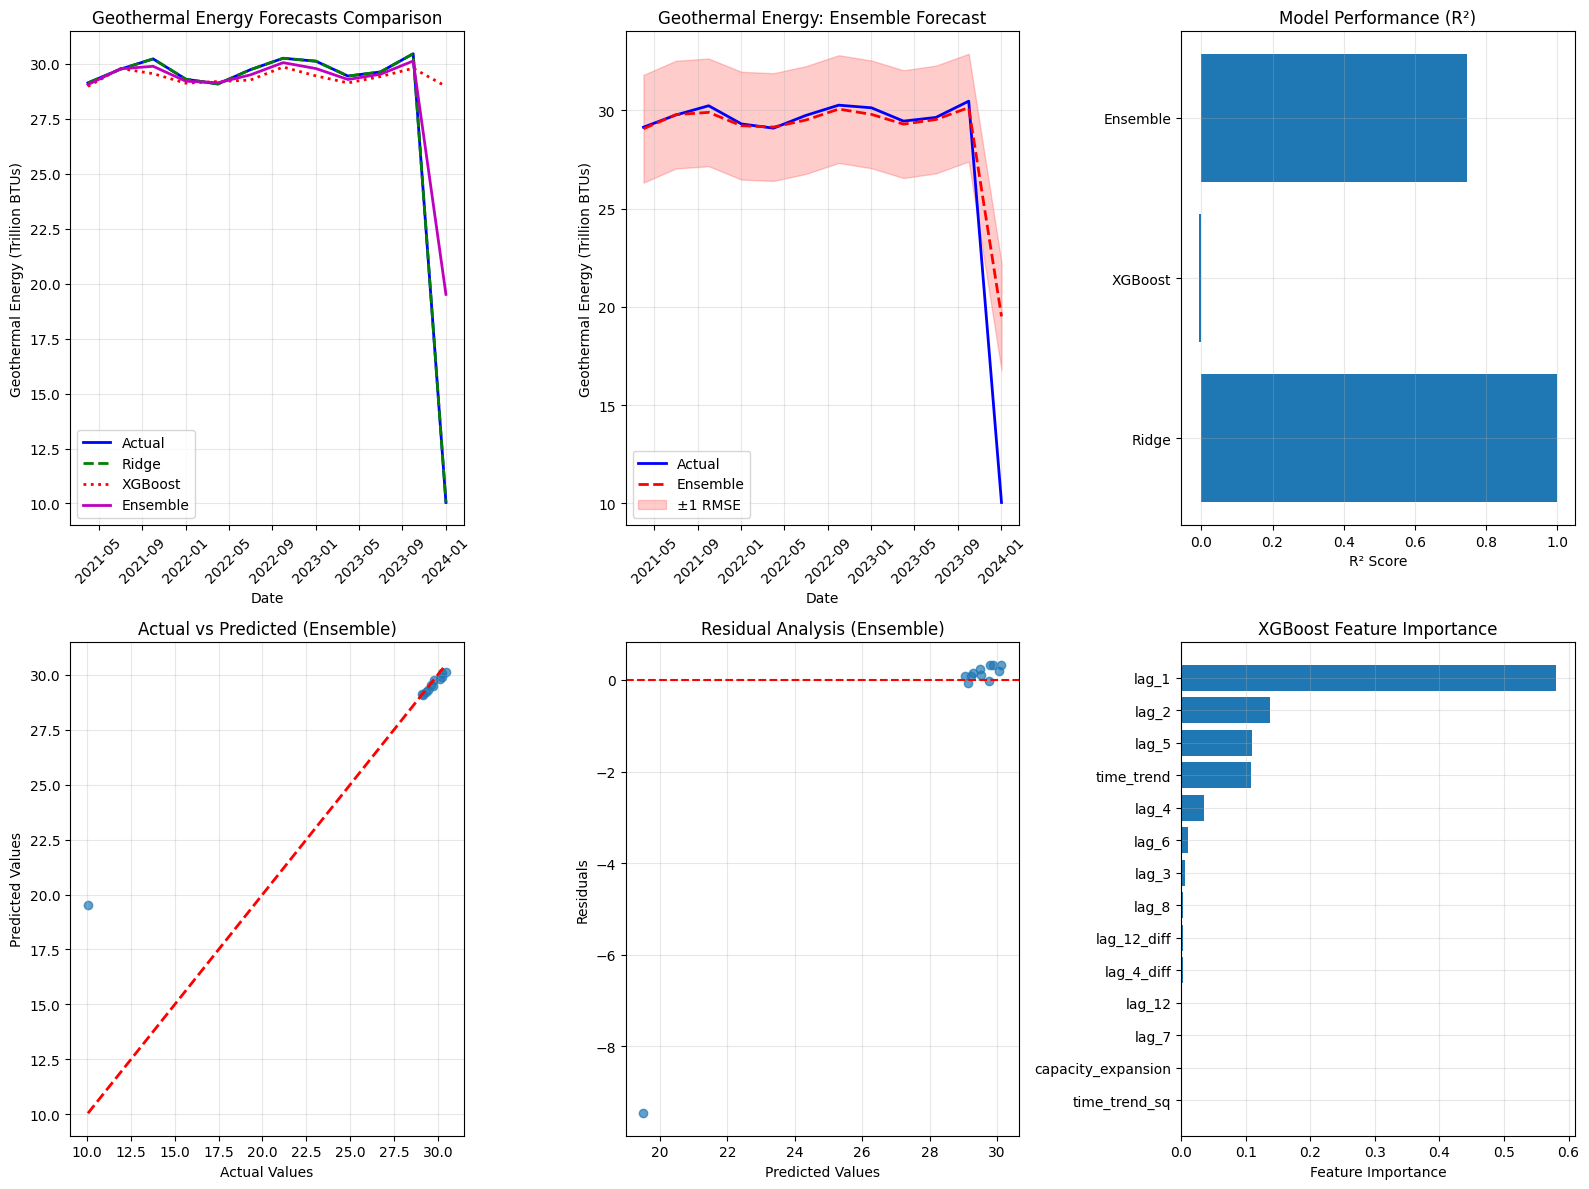

In [11]:
# 10. Visualization
print("\n10. Visualization")
print("=" * 50)

plt.figure(figsize=(16, 12))

# Plot 1: Time series with all predictions
plt.subplot(2, 3, 1)
plt.plot(test["Date"], y_test, "b-", label="Actual", linewidth=2)
plt.plot(test["Date"], y_pred_ridge, "g--", label="Ridge", linewidth=2)
plt.plot(test["Date"], y_pred_xgb, "r:", label="XGBoost", linewidth=2)
plt.plot(test["Date"], y_pred_ens, "m-", label="Ensemble", linewidth=2)
plt.title("Geothermal Energy Forecasts Comparison")
plt.xlabel("Date")
plt.ylabel("Geothermal Energy (Trillion BTUs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Ensemble forecast with confidence band
plt.subplot(2, 3, 2)
plt.plot(test["Date"], y_test, "b-", label="Actual", linewidth=2)
plt.plot(test["Date"], y_pred_ens, "r--", label="Ensemble", linewidth=2)
plt.fill_between(
    test["Date"],
    y_pred_ens - rmse_ens,
    y_pred_ens + rmse_ens,
    color="r", alpha=0.2, label="±1 RMSE"
)
plt.title("Geothermal Energy: Ensemble Forecast")
plt.xlabel("Date")
plt.ylabel("Geothermal Energy (Trillion BTUs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 3: Model performance comparison
plt.subplot(2, 3, 3)
plt.barh(results_df['Model'], results_df['R²'])
plt.xlabel('R² Score')
plt.title('Model Performance (R²)')
plt.grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted (Ensemble)
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_ens, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Ensemble)')
plt.grid(True, alpha=0.3)

# Plot 5: Residuals
plt.subplot(2, 3, 5)
residuals = y_test - y_pred_ens
plt.scatter(y_pred_ens, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Ensemble)')
plt.grid(True, alpha=0.3)

# Plot 6: Feature importance (XGBoost)
plt.subplot(2, 3, 6)
importance = xgb.feature_importances_
feature_names = feature_cols
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



11. Historical Trend Analysis


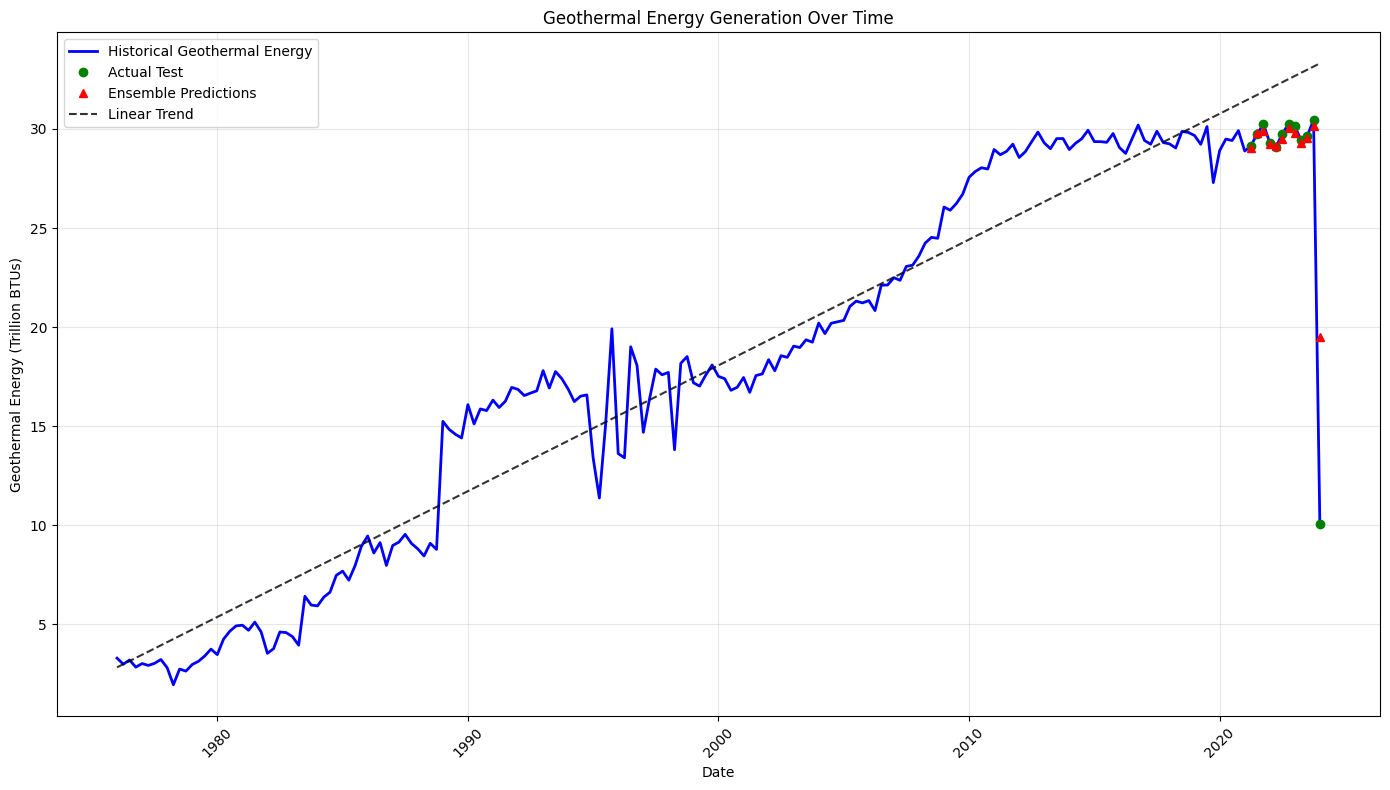

Geothermal Energy Growth Analysis:
Starting level: 3.30 BTUs
Current level: 10.05 BTUs
Growth factor: 3.0x
Annual growth rate: 2.3%


In [14]:
# 11. Historical Trend Analysis
print("\n11. Historical Trend Analysis")
print("=" * 50)

# Plot full time series with trend analysis
plt.figure(figsize=(14, 8))
plt.plot(df_agg['Date'], df_agg['y'], 'b-', linewidth=2, label='Historical Geothermal Energy')
plt.plot(test['Date'], y_test, 'go', markersize=6, label='Actual Test')
plt.plot(test['Date'], y_pred_ens, 'r^', markersize=6, label='Ensemble Predictions')

# Add trend line
z = np.polyfit(range(len(df_agg)), df_agg['y'], 1)
p = np.poly1d(z)
plt.plot(df_agg['Date'], p(range(len(df_agg))), "k--", alpha=0.8, label='Linear Trend')

plt.title('Geothermal Energy Generation Over Time')
plt.xlabel('Date')
plt.ylabel('Geothermal Energy (Trillion BTUs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze geothermal growth pattern
print("Geothermal Energy Growth Analysis:")
print(f"Starting level: {df_agg['y'].iloc[0]:.2f} BTUs")
print(f"Current level: {df_agg['y'].iloc[-1]:.2f} BTUs")
print(f"Growth factor: {df_agg['y'].iloc[-1] / df_agg['y'].iloc[0]:.1f}x")
print(
    f"Annual growth rate: {((df_agg['y'].iloc[-1] / df_agg['y'].iloc[0]) ** (1 / ((df_agg['Date'].iloc[-1] - df_agg['Date'].iloc[0]).days / 365.25)) - 1) * 100:.1f}%")

# Identify capacity expansion periods
expansion_periods = df_agg[df_agg['capacity_expansion'] == 1]
if len(expansion_periods) > 0:
    print(f"\nCapacity expansion periods detected: {len(expansion_periods)}")
    print("Expansion quarters:")
    for _, row in expansion_periods.iterrows():
        print(f"  {row['Date'].year} Q{row['Date'].quarter}: {row['y']:.2f} BTUs")


12. Geothermal Technology Development Analysis


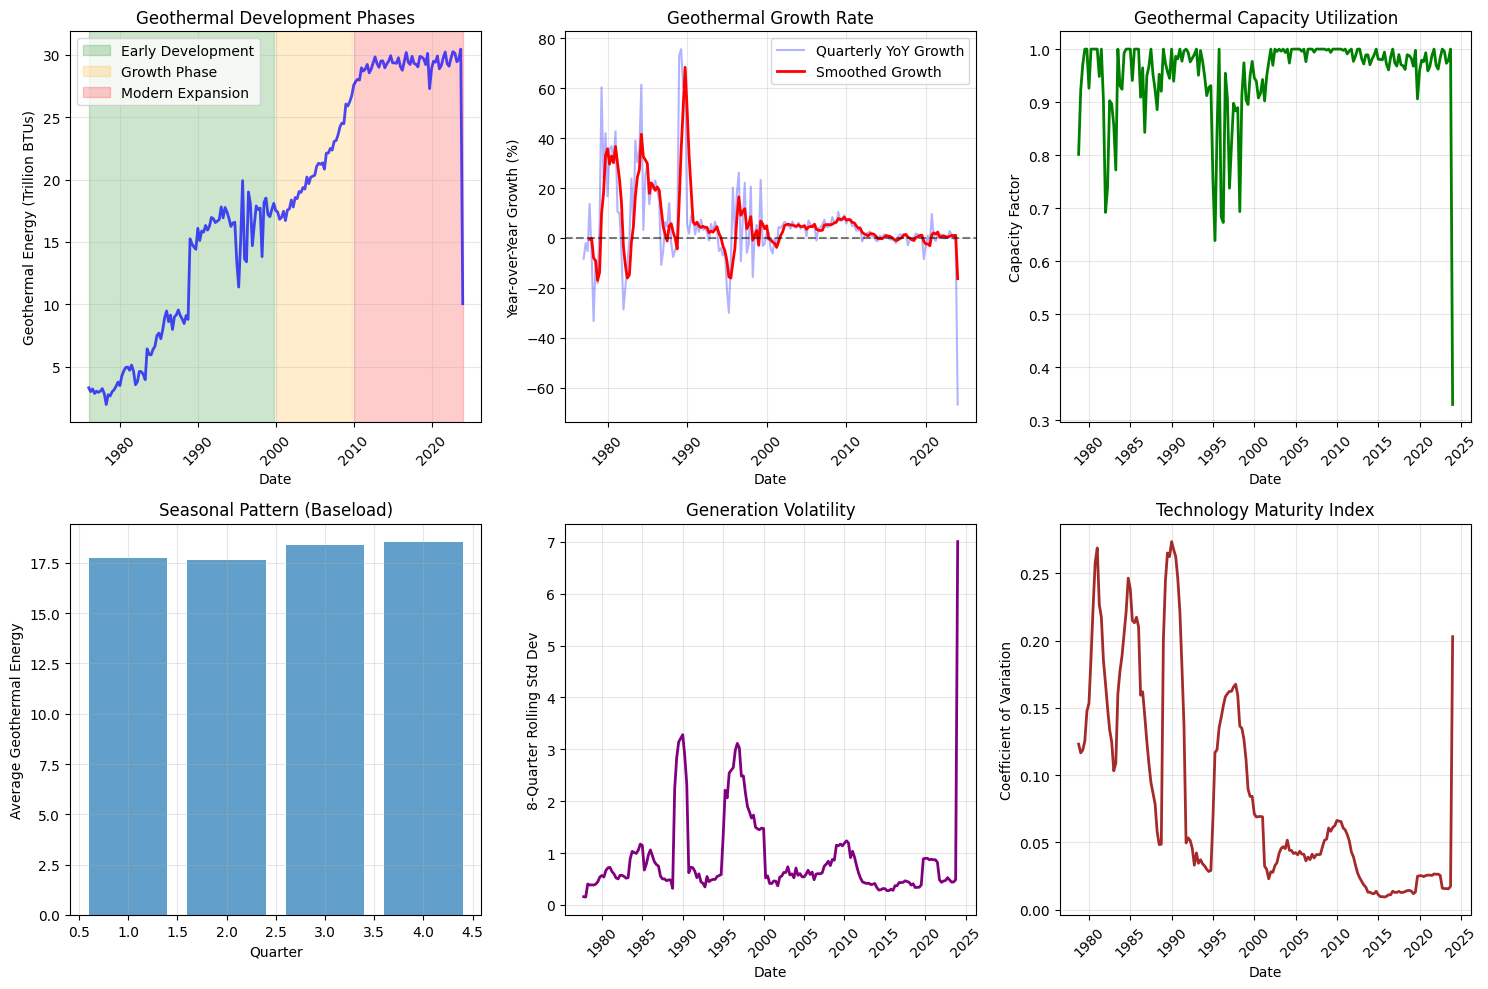

Early Development: Avg 10.48 BTUs, Growth 9.8%/yr
Growth Phase: Avg 20.78 BTUs, Growth 4.2%/yr
Modern Expansion: Avg 28.95 BTUs, Growth -0.2%/yr


In [15]:
# 12. Geothermal Technology Development Analysis
print("\n12. Geothermal Technology Development Analysis")
print("=" * 50)

# Analyze different phases of geothermal development
plt.figure(figsize=(15, 10))

# Phase analysis
phase1 = df_agg[df_agg['Date'] < '2000-01-01']  # Early development
phase2 = df_agg[(df_agg['Date'] >= '2000-01-01') & (df_agg['Date'] < '2010-01-01')]  # Growth phase
phase3 = df_agg[df_agg['Date'] >= '2010-01-01']  # Modern expansion

plt.subplot(2, 3, 1)
plt.plot(df_agg['Date'], df_agg['y'], 'b-', linewidth=2, alpha=0.7)

# Highlight different phases
if len(phase1) > 0:
    plt.axvspan(phase1['Date'].min(), phase1['Date'].max(), 
                alpha=0.2, color='green', label='Early Development')
if len(phase2) > 0:
    plt.axvspan(phase2['Date'].min(), phase2['Date'].max(), 
                alpha=0.2, color='orange', label='Growth Phase')
if len(phase3) > 0:
    plt.axvspan(phase3['Date'].min(), phase3['Date'].max(), 
                alpha=0.2, color='red', label='Modern Expansion')

plt.xlabel('Date')
plt.ylabel('Geothermal Energy (Trillion BTUs)')
plt.title('Geothermal Development Phases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Growth rate analysis
plt.subplot(2, 3, 2)
df_agg['yoy_growth'] = df_agg['y'].pct_change(periods=4) * 100
df_agg['yoy_growth_smooth'] = df_agg['yoy_growth'].rolling(window=4).mean()

plt.plot(df_agg['Date'], df_agg['yoy_growth'], 'b-', alpha=0.3, label='Quarterly YoY Growth')
plt.plot(df_agg['Date'], df_agg['yoy_growth_smooth'], 'r-', linewidth=2, label='Smoothed Growth')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Year-over-Year Growth (%)')
plt.title('Geothermal Growth Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Capacity factor analysis (stability indicator)
plt.subplot(2, 3, 3)
df_agg['capacity_factor'] = df_agg['y'] / df_agg['y'].rolling(window=12).max()
plt.plot(df_agg['Date'], df_agg['capacity_factor'], 'g-', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Capacity Factor')
plt.title('Geothermal Capacity Utilization')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Seasonal analysis (geothermal is baseload)
plt.subplot(2, 3, 4)
df_agg['Quarter'] = df_agg['Date'].dt.quarter
seasonal_pattern = df_agg.groupby('Quarter')['y'].mean()
plt.bar(seasonal_pattern.index, seasonal_pattern.values, alpha=0.7)
plt.xlabel('Quarter')
plt.ylabel('Average Geothermal Energy')
plt.title('Seasonal Pattern (Baseload)')
plt.grid(True, alpha=0.3)

# Volatility analysis
plt.subplot(2, 3, 5)
df_agg['volatility'] = df_agg['y'].rolling(window=8).std()
plt.plot(df_agg['Date'], df_agg['volatility'], 'purple', linewidth=2)
plt.xlabel('Date')
plt.ylabel('8-Quarter Rolling Std Dev')
plt.title('Generation Volatility')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Technology maturity indicator
plt.subplot(2, 3, 6)
df_agg['maturity_index'] = df_agg['y'].rolling(window=12).std() / df_agg['y'].rolling(window=12).mean()
plt.plot(df_agg['Date'], df_agg['maturity_index'], 'brown', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Coefficient of Variation')
plt.title('Technology Maturity Index')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate phase statistics
phases = {'Early Development': phase1, 'Growth Phase': phase2, 'Modern Expansion': phase3}
for phase_name, phase_data in phases.items():
    if len(phase_data) > 0:
        avg_growth = phase_data['yoy_growth'].mean()
        print(f"{phase_name}: Avg {phase_data['y'].mean():.2f} BTUs, Growth {avg_growth:.1f}%/yr")



13. Baseload Characteristics Analysis


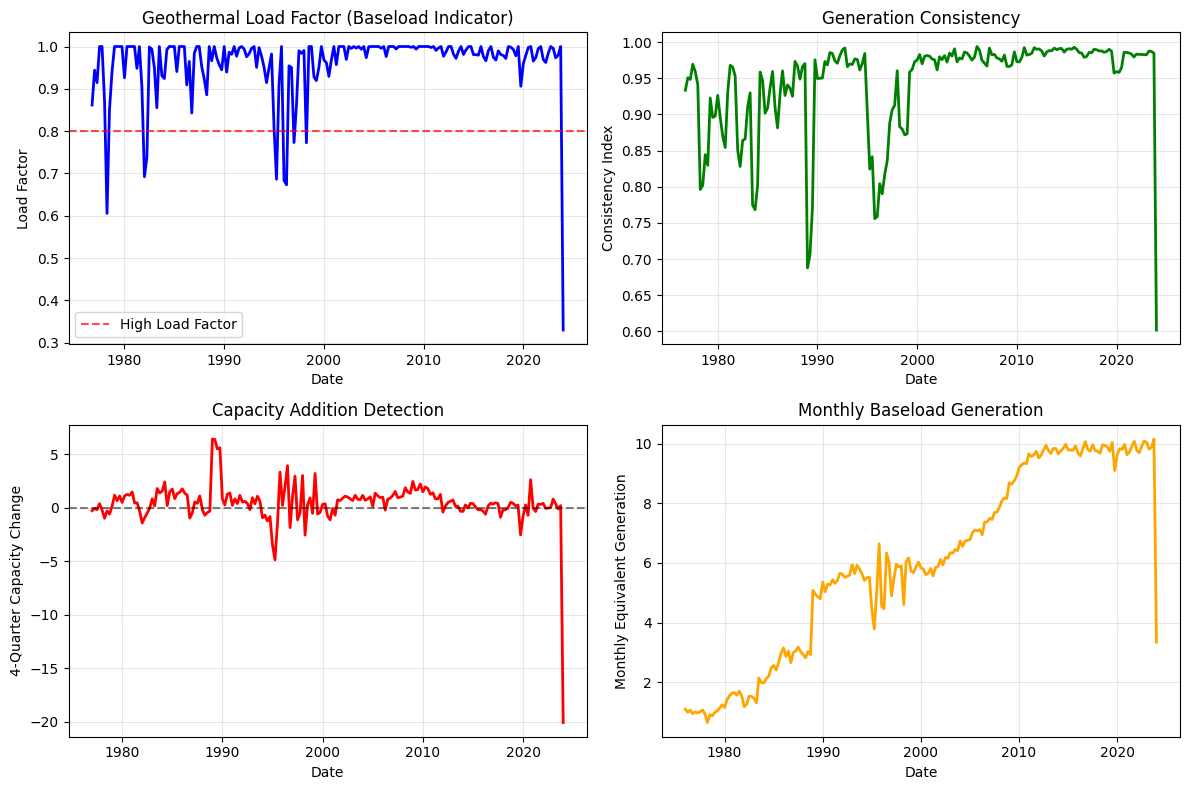

Baseload Characteristics:
Recent load factor: 0.930
Recent consistency: 0.952
Seasonal variation: 9.33 BTUs


In [17]:
# 13. Baseload Characteristics Analysis
print("\n13. Baseload Characteristics Analysis")
print("=" * 50)

# Geothermal is baseload power - analyze consistency
plt.figure(figsize=(12, 8))

# Load factor analysis
plt.subplot(2, 2, 1)
df_agg['load_factor'] = df_agg['y'] / df_agg['y'].rolling(window=4).max()
plt.plot(df_agg['Date'], df_agg['load_factor'], 'b-', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='High Load Factor')
plt.xlabel('Date')
plt.ylabel('Load Factor')
plt.title('Geothermal Load Factor (Baseload Indicator)')
plt.legend()
plt.grid(True, alpha=0.3)

# Consistency analysis
plt.subplot(2, 2, 2)
df_agg['consistency'] = 1 - (df_agg['y'].rolling(window=4).std() / df_agg['y'].rolling(window=4).mean())
plt.plot(df_agg['Date'], df_agg['consistency'], 'g-', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Consistency Index')
plt.title('Generation Consistency')
plt.grid(True, alpha=0.3)

# Capacity additions detection
plt.subplot(2, 2, 3)
df_agg['capacity_jump'] = df_agg['y'].diff().rolling(window=4).sum()
plt.plot(df_agg['Date'], df_agg['capacity_jump'], 'r-', linewidth=2)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('4-Quarter Capacity Change')
plt.title('Capacity Addition Detection')
plt.grid(True, alpha=0.3)

# Monthly equivalent generation (assuming quarterly data)
plt.subplot(2, 2, 4)
df_agg['monthly_equiv'] = df_agg['y'] / 3
plt.plot(df_agg['Date'], df_agg['monthly_equiv'], 'orange', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Monthly Equivalent Generation')
plt.title('Monthly Baseload Generation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Baseload characteristics summary
print("Baseload Characteristics:")
recent_load_factor = df_agg['load_factor'].tail(12).mean()
recent_consistency = df_agg['consistency'].tail(12).mean()
print(f"Recent load factor: {recent_load_factor:.3f}")
print(f"Recent consistency: {recent_consistency:.3f}")
print(f"Seasonal variation: {df_agg.groupby('Quarter')['y'].std().mean():.2f} BTUs")


14. Future Predictions
Future Geothermal Energy Predictions (Next 4 Quarters):
        Date  Quarter  Year  Predicted_Geothermal_Energy
0 2024-04-30        2  2024                        12.96
1 2024-07-31        3  2024                        14.56
2 2024-10-31        4  2024                        17.45
3 2025-01-31        1  2025                        18.21


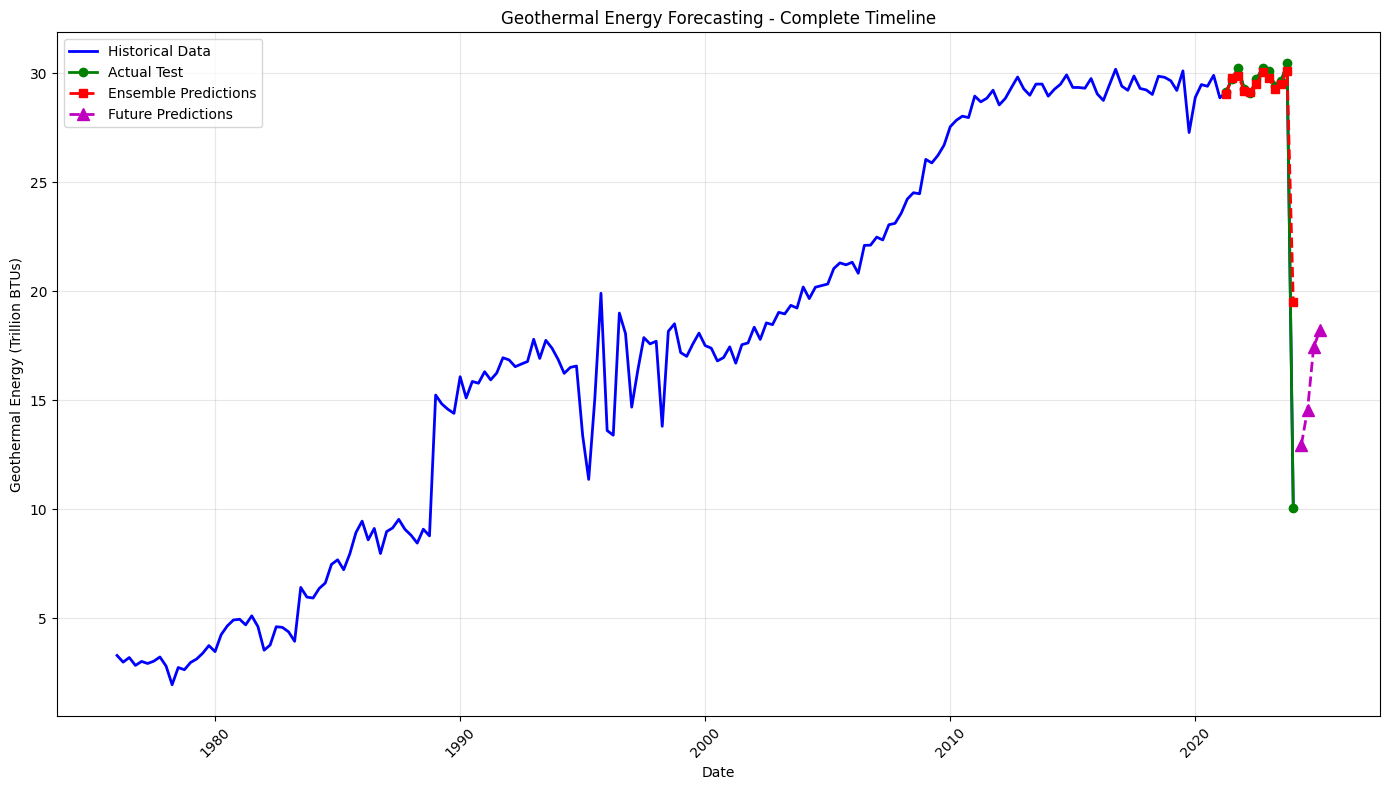


Prediction Confidence (±1 std dev): 2.66 BTUs
Future predictions range: 12.96 to 18.21 BTUs

Geothermal Energy Insights:
Projected growth: -36.6% over next year
⚠ Geothermal growth may be slowing - check for capacity constraints


In [19]:
# 14. Future Predictions
print("\n14. Future Predictions")
print("=" * 50)

if r2_ens > 0:
    # Create future features based on the pattern
    future_predictions = []
    current_series = list(df_agg['y'].values)

    for step in range(4):
        # Create features for next prediction
        future_features = []

        # Lag features
        for lag in range(1, 9):
            if len(current_series) >= lag:
                future_features.append(current_series[-lag])
            else:
                future_features.append(df_agg['y'].mean())

        # Lag 12 (annual)
        if len(current_series) >= 12:
            future_features.append(current_series[-12])
        else:
            future_features.append(df_agg['y'].mean())

        # Differences
        if len(current_series) >= 4:
            lag_4_diff = current_series[-1] - current_series[-4]
        else:
            lag_4_diff = 0
        future_features.append(lag_4_diff)

        if len(current_series) >= 12:
            lag_12_diff = current_series[-1] - current_series[-12]
        else:
            lag_12_diff = 0
        future_features.append(lag_12_diff)

        # Trend features
        next_time = len(current_series) + step
        future_features.append(next_time)
        future_features.append(next_time ** 2)

        # Capacity expansion (conservatively set to 0 for future)
        future_features.append(0)

        # Scale features
        future_features_scaled = scaler.transform([future_features])

        # Make prediction
        pred = ensemble.predict(future_features_scaled)[0]
        # Ensure non-negative predictions
        pred = max(0, pred)
        future_predictions.append(pred)

        # Add prediction to series for next iteration
        current_series.append(pred)

    # Create future dates
    last_date = test['Date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=4, freq='3M')

    # Display predictions
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Quarter': [(d.month - 1) // 3 + 1 for d in future_dates],
        'Year': [d.year for d in future_dates],
        'Predicted_Geothermal_Energy': future_predictions
    })

    print("Future Geothermal Energy Predictions (Next 4 Quarters):")
    print(future_df.round(2))

    # Plot with future predictions
    plt.figure(figsize=(14, 8))
    plt.plot(df_agg['Date'], df_agg['y'], 'b-', label='Historical Data', linewidth=2)
    plt.plot(test['Date'], y_test, 'g-', label='Actual Test', linewidth=2, marker='o')
    plt.plot(test['Date'], y_pred_ens, 'r--', label='Ensemble Predictions', linewidth=2, marker='s')
    plt.plot(future_dates, future_predictions, 'm-', label='Future Predictions',
             linewidth=2, marker='^', linestyle='--', markersize=8)

    plt.xlabel('Date')
    plt.ylabel('Geothermal Energy (Trillion BTUs)')
    plt.title('Geothermal Energy Forecasting - Complete Timeline')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate prediction confidence
    pred_std = np.std(y_test - y_pred_ens)
    print(f"\nPrediction Confidence (±1 std dev): {pred_std:.2f} BTUs")
    print(f"Future predictions range: {min(future_predictions):.2f} to {max(future_predictions):.2f} BTUs")

    # Geothermal specific insights
    print("\nGeothermal Energy Insights:")
    if len(future_predictions) > 0:
        avg_future = np.mean(future_predictions)
        recent_avg = np.mean(df_agg['y'].tail(4))
        growth_projection = ((avg_future / recent_avg) - 1) * 100
        print(f"Projected growth: {growth_projection:.1f}% over next year")

        # Geothermal typically shows steady growth with new capacity
        if growth_projection > 5:
            print("✓ Geothermal shows strong growth - likely new capacity additions")
        elif growth_projection > 0:
            print("✓ Geothermal shows steady growth - consistent with baseload expansion")
        else:
            print("⚠ Geothermal growth may be slowing - check for capacity constraints")

else:
    print("Model performance too poor for reliable future predictions")